# Fine tuning a VLM for Object Detection Grounding using TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_


> 🚨 **WARNING**: This notebook is resource-intensive and requires substantial computational power. If you're running it in Colab, it will utilize an **A100 GPU**.

**🔍 What You'll Learn**

In this recipe, we'll demonstrate how to fine-tune a [Vision-Language Model (VLM)](https://huggingface.co/blog/vlms-2025) for **object detection grounding** using [TRL](https://huggingface.co/docs/trl/en/index).

Traditionally, object detection involves identifying a predefined set of classes (e.g., "car", "person", "dog") within an image. However, this paradigm shifted with models like [Grounding DINO](https://huggingface.co/IDEA-Research/grounding-dino-base), [GLIP](https://github.com/microsoft/GLIP), or [OWL-ViT](https://arxiv.org/abs/2205.06230), which introduced **open-ended object detection**—enabling models to detect *any* class described in natural language.

Grounding goes a step further by adding contextual understanding. Instead of just detecting a "car", grounded detection can locate the **"car on the left"**, or the **"red car behind the tree"**. This provides a more nuanced and powerful approach to object detection.

In this recipe, we'll walk through how to fine-tune a VLM for this task. Specifically, we'll use [PaliGemma 2](https://huggingface.co/blog/paligemma2), a Vision-Language Model developed by Google that supports object detection out of the box. While not all VLMs offer detection capabilities by default, the concepts and steps in this notebook can be adapted for models without built-in object detection as well.

To train our model, we'll use [RefCOCO](https://paperswithcode.com/dataset/refcoco), an extension of the popular COCO dataset, designed specifically for **referring expression comprehension**—that is, combining object detection with grounding through natural language.

This recipe also builds upon my recent release of [this Space](https://huggingface.co/spaces/sergiopaniego/vlm_object_understanding), which lets you compare different VLMs on object understanding tasks such as object detection, keypoint detection, and more.

📚 **Additional Resources**  
At the end of this notebook, you'll find extra resources if you're interested in exploring the topic further.

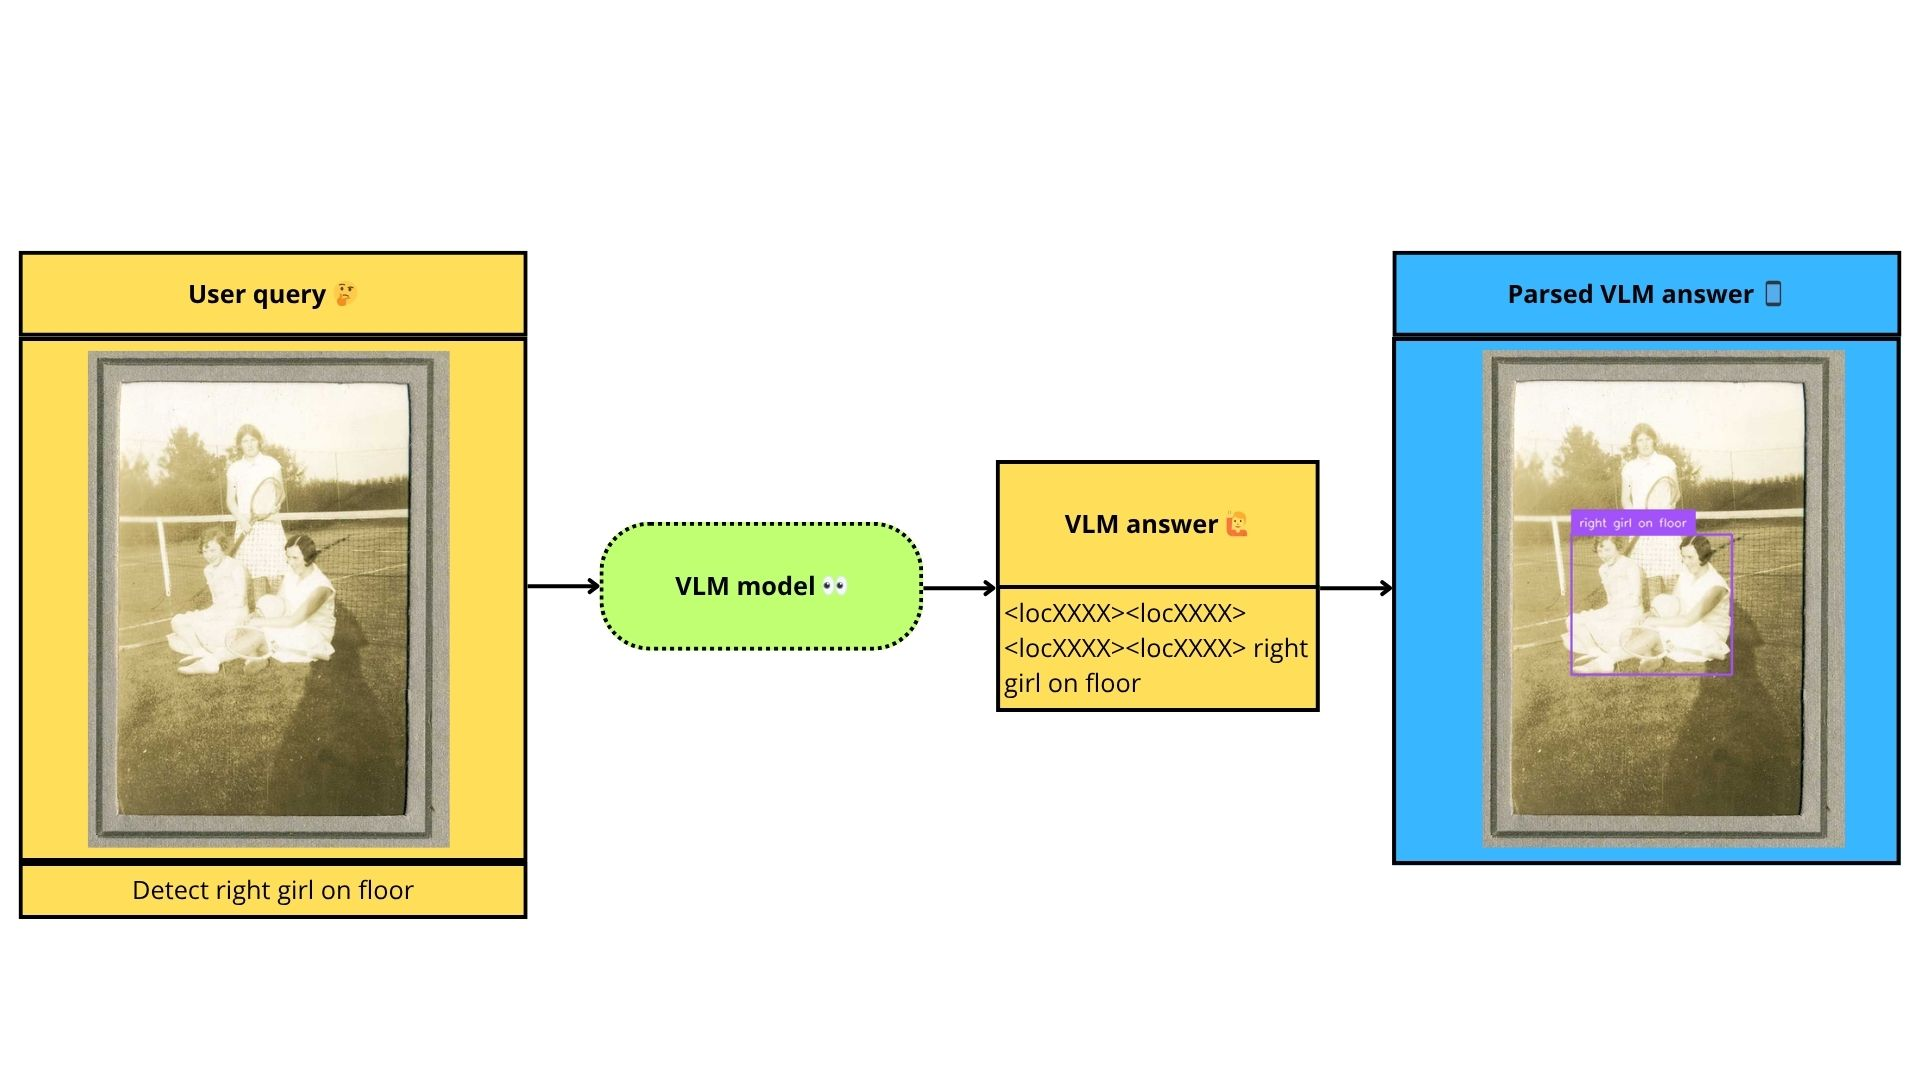

## 1. Install dependencies

Let's start by installing the required dependencies:

In [ ]:
!pip install -Uq transformers datasets trl supervision albumentations

We'll log in to our Hugging Face [account](https://huggingface.co/join) to access gated models and save our trained checkpoints.  
You'll need an access [token](https://huggingface.co/settings/tokens) 🗝️.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. 📁 Load Dataset

For this example, we'll use [RefCOCO](https://paperswithcode.com/dataset/refcoco), a dataset that includes grounded object detection annotations—enabling more robust and context-aware detection.

To keep things simple and efficient, we'll work with a subset of the dataset.

In [ ]:
from datasets import load_dataset
refcoco_dataset = load_dataset("jxu124/refcoco",split='train[:5%]')

After loading it, let's see what's inside:

In [2]:
refcoco_dataset

Dataset({
    features: ['sent_ids', 'file_name', 'ann_id', 'ref_id', 'image_id', 'split', 'sentences', 'category_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id'],
    num_rows: 2120
})

We can see that the dataset contains useful information such as the `bbox` and `captions` columns.  
However, the image itself isn't directly accessible from these fields. For more details about the image source, we can inspect the `raw_image_info` column.

In [3]:
refcoco_dataset[10]['raw_image_info']

'{"license": 4, "file_name": "COCO_train2014_000000581739.jpg", "coco_url": "http://mscoco.org/images/581739", "height": 480, "width": 640, "date_captured": "2013-11-23 18:13:08", "flickr_url": "http://farm3.staticflickr.com/2582/3858684718_c8d919054d_z.jpg", "id": 581739}'

### 2.1 🖼️ Add Images to the Dataset

While we could link each example to the corresponding image in the [COCO dataset](https://cocodataset.org/), we'll simplify the process by downloading the images directly from Flickr.

However, this approach may result in some missing images, so we’ll need to handle those cases accordingly.

In [ ]:
import json
import requests
from PIL import Image
from io import BytesIO

def add_image(example):
    try:
        raw_info = json.loads(example['raw_image_info'])  # convertir string a dict
        url = raw_info.get('flickr_url', None)
        if url:
            response = requests.get(url, timeout=10)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            example['image'] = image
        else:
            example['image'] = None
    except Exception as e:
        print(f"Error loading image: {e}")
        example['image'] = None
    return example

refcoco_dataset_with_images = refcoco_dataset.map(add_image, desc="Adding image from flickr", num_proc=16)

Awesome! Our images are now downloaded and ready to go.

In [5]:
refcoco_dataset_with_images

Dataset({
    features: ['sent_ids', 'file_name', 'ann_id', 'ref_id', 'image_id', 'split', 'sentences', 'category_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id', 'image'],
    num_rows: 2120
})

Next, let's filter the dataset to include only samples that have an associated image:

In [6]:
filtered_dataset = refcoco_dataset_with_images.filter(
    lambda example: example['image'] is not None,
    desc="Removing failed image downloads"
)

Removing failed image downloads:   0%|          | 0/2120 [00:00<?, ? examples/s]

### 2.2 Remove Unneeded Columns

In [7]:
filtered_dataset

Dataset({
    features: ['sent_ids', 'file_name', 'ann_id', 'ref_id', 'image_id', 'split', 'sentences', 'category_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'bbox', 'captions', 'global_image_id', 'anns_id', 'image'],
    num_rows: 1691
})

The dataset contains many columns that we won't need for this task.  
Let's simplify it by keeping only the `'bbox'`, `'captions'`, and `'image'` columns.

In [8]:
# We need image, captions, bbox
filtered_dataset = filtered_dataset.remove_columns(['sent_ids', 'file_name', 'ann_id', 'ref_id', 'image_id', 'split', 'sentences', 'category_id', 'raw_anns', 'raw_image_info', 'raw_sentences', 'image_path', 'global_image_id', 'anns_id'])

It looks much better now!

In [9]:
filtered_dataset

Dataset({
    features: ['bbox', 'captions', 'image'],
    num_rows: 1691
})

### 2.3 Separate Captions into Unique Samples

One final step: each sample currently has multiple captions. To simplify the dataset, we'll split these so that each caption becomes a unique sample.

In [10]:
def explode_captions_batch(batch):
    new_images = []
    new_bboxes = []
    new_captions = []

    for image, bbox, captions in zip(batch["image"], batch["bbox"], batch["captions"]):
        for caption in captions:
            new_images.append(image)
            new_bboxes.append(bbox)
            new_captions.append(caption)

    return {
        "image": new_images,
        "bbox": new_bboxes,
        "caption": new_captions,
    }

filtered_dataset = filtered_dataset.map(
    explode_captions_batch,
    batched=True,
    batch_size=100,
    num_proc=4,
    remove_columns=filtered_dataset.column_names
)

Map (num_proc=4):   0%|          | 0/1691 [00:00<?, ? examples/s]

Now that everything is prepared, let's take a look at an example!

In [11]:
filtered_dataset[10]['caption']

'right girl on floor'

In [12]:
filtered_dataset[10]['bbox']

[114.57, 237.84, 320.83, 417.49]

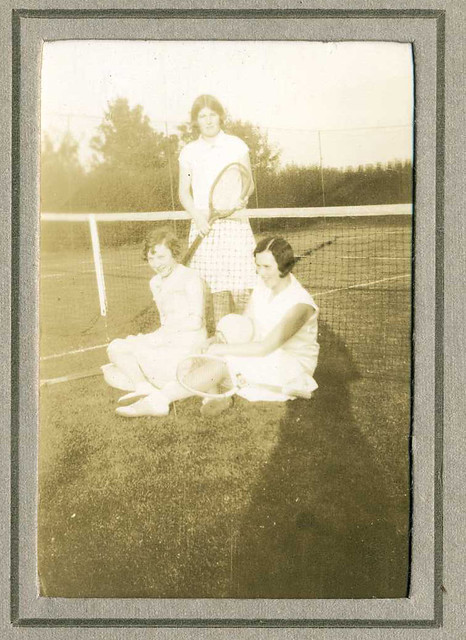

In [13]:
filtered_dataset[10]['image']

### 2.4 Display a Sample with Bounding Boxes

Our dataset preparation is complete. Now, let's visualize the bounding boxes on an image from a sample.  
To do this, we'll create an auxiliary function that we can reuse throughout the recipe.

We'll use the [supervision](https://supervision.roboflow.com/latest/) library to assist with displaying the bounding boxes.

In [14]:
labels = [(filtered_dataset[10]['caption'], filtered_dataset[10]['bbox'])]

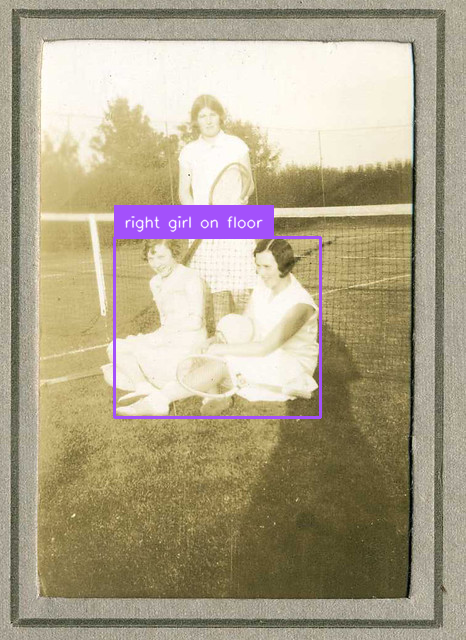

In [15]:
import supervision as sv
import numpy as np

def get_annotated_image(image, parsed_labels):
    if not parsed_labels:
        return image

    xyxys = []
    labels = []

    for label, bbox in parsed_labels:
        xyxys.append(bbox)
        labels.append(label)

    detections = sv.Detections(xyxy=np.array(xyxys))

    bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    annotated_image = bounding_box_annotator.annotate(
        scene=image, detections=detections
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections, labels=labels
    )

    return annotated_image

annotated_image = get_annotated_image(filtered_dataset[10]['image'], labels)
annotated_image

Great! We can now see the grounding caption associated with each bounding box.


### 2.5 Divide the Dataset

Our dataset is ready, but before we proceed, let's split it into training and validation sets for proper model evaluation.


In [16]:
split_dataset = filtered_dataset.train_test_split(test_size=0.2, seed=42, shuffle=False)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']
train_dataset, val_dataset

(Dataset({
     features: ['bbox', 'image', 'caption'],
     num_rows: 3863
 }),
 Dataset({
     features: ['bbox', 'image', 'caption'],
     num_rows: 966
 }))

## 3. Check the Pretrained Model with the Dataset

As mentioned earlier, we'll be using **PaliGemma 2** as our model since it already includes object detection capabilities, which simplifies our workflow.

If we were using a Vision-Language Model (VLM) without built-in object detection capabilities, we would likely need to train it first to acquire them.

For more on this, check out our [project on Gemma 3](https://huggingface.co/blog/gemma3) that covers this training process in detail.

Now, let's load the model and processor. We'll use the pretrained model [google/paligemma2-3b-pt-448](https://huggingface.co/google/paligemma2-3b-pt-448), which is not fine-tuned for conversational tasks.

In [17]:
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
)
import torch

model_id = "google/paligemma2-3b-pt-448"

model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto").eval()
processor = PaliGemmaProcessor.from_pretrained(model_id, use_fast=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3.1 Inference on One Sample

Let's evaluate the current performance of the model on a single image and caption.

In [18]:
image = train_dataset[10]['image']
caption = train_dataset[10]['caption']

Since our model is not an instruct model, the input should be formatted as follows:

```
<image>detect [CAPTION]
```

Here, `<image>` represents the image token, followed by the keyword `detect` to specify the object detection task, and then the caption describing what to detect.

This format will produce a specific output, as we will see next.

In [19]:
prompt = f"<image>detect {caption}"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(torch.bfloat16).to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    output = processor.decode(generation, skip_special_tokens=True)
    print(output)

<loc0366><loc0220><loc0666><loc0457> right girl on floor ; <loc0150><loc0386><loc0535><loc0568> right girl on floor ; <loc0377><loc0438><loc0659><loc0707> right girl on floor


We can see that the model generates location tokens in a special format like `<locXXXX>...`, followed by the detected category. Each detection is separated by a `;`.

These location tokens follow the PaliGemma format, which is specific to the model and relative to the input size—`448x448` in this case, as indicated by the model name.

To display the detections correctly, we need to convert these tokens back to a usable format. Let's create an auxiliary function to handle this conversion:

In [20]:
import re

# https://github.com/ariG23498/gemma3-object-detection/blob/main/utils.py#L17 thanks to Aritra Roy Gosthipaty
def parse_paligemma_labels(label, width, height):
    predictions = label.strip().split(";")
    results = []

    for pred in predictions:
        pred = pred.strip()
        if not pred:
            continue

        loc_pattern = r"<loc(\d{4})>"
        locations = [int(loc) for loc in re.findall(loc_pattern, pred)]

        if len(locations) != 4:
            continue

        category = pred.split(">")[-1].strip()

        y1_norm, x1_norm, y2_norm, x2_norm = locations
        x1 = (x1_norm / 1024) * width
        y1 = (y1_norm / 1024) * height
        x2 = (x2_norm / 1024) * width
        y2 = (y2_norm / 1024) * height

        results.append((category, [x1, y1, x2, y2]))

    return results

Now, we can use this function to parse the PaliGemma labels into the common COCO format.

In [21]:
width, height = image.size
parsed_labels = parse_paligemma_labels(output, width, height)
parsed_labels

[('right girl on floor', [100.1171875, 228.75, 207.970703125, 416.25]),
 ('right girl on floor', [175.66015625, 93.75, 258.484375, 334.375]),
 ('right girl on floor', [199.32421875, 235.625, 321.740234375, 411.875])]

Next, we can use the previous function to retrieve the image.  
Let's display it along with the parsed bounding boxes!


In [22]:
annotated_image = get_annotated_image(image, parsed_labels)

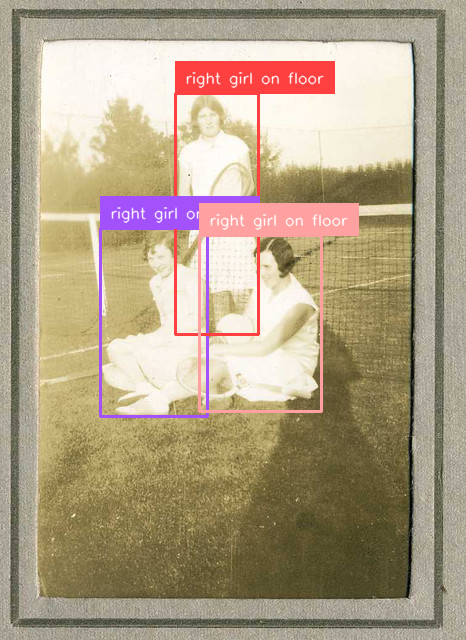

In [23]:
annotated_image

We can see that the model performs well on object detection, but it struggles a bit with grounding.  
For example, it labels all three people as the **"right girl on floor"** instead of just one.  

Let's work on improving that! 🙂

## 4. Fine-Tuning the Model Using the Dataset with LoRA and TRL

To fine-tune the Vision-Language Model (VLM), we will leverage [LoRA](https://huggingface.co/docs/peft/en/package_reference/lora) and [TRL](https://github.com/huggingface/trl).  

Let's start by configuring LoRA:

In [24]:
from peft import LoraConfig, get_peft_model

target_modules = [
    "q_proj",
    "v_proj",
    "fc1",
    "fc2",
    "linear",
    "gate_proj",
    "up_proj",
    "down_proj"
]

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 12,165,888 || all params: 3,045,293,040 || trainable%: 0.3995


Next, let's configure the [SFT training](https://huggingface.co/docs/trl/en/sft_trainer) pipeline from TRL.  
This pipeline simplifies the training process by abstracting much of the underlying complexity and managing it for us.

In [25]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="paligemma2-3b-pt-448-od-grounding",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    learning_rate=1e-05,
    num_train_epochs=2,
    logging_steps=10,
    eval_steps=100,
    eval_strategy="steps",
    save_steps=10,
    bf16=True,
    report_to=["tensorboard"],
    dataset_kwargs={'skip_prepare_dataset': True},
    remove_unused_columns=False,
    push_to_hub=True,
    dataloader_pin_memory=False,
    label_names=["labels"],
)

We're almost ready!  
Next, we'll define a few auxiliary functions to handle object detection within the collator.  
These functions are straightforward and self-explanatory.

In [26]:
def coco_to_xyxy(coco_bbox):
    x, y, width, height = coco_bbox
    x1, y1 = x, y
    x2, y2 = x + width, y + height
    return [x1, y1, x2, y2]

def convert_to_detection_string(bboxs, image_width, image_height, category):
    def format_location(value, max_value):
        return f"<loc{int(round(value * 1024 / max_value)):04}>"

    detection_strings = []
    for bbox in bboxs:
        x1, y1, x2, y2 = coco_to_xyxy(bbox)
        locs = [
            format_location(y1, image_height),
            format_location(x1, image_width),
            format_location(y2, image_height),
            format_location(x2, image_width),
        ]
        detection_string = "".join(locs) + f" {category}"
        detection_strings.append(detection_string)
    return " ; ".join(detection_strings)

def format_objects(example):
    height = example["height"]
    width = example["width"]
    bboxs = example["bbox"]
    category = example['caption'][0]
    formatted_objects = convert_to_detection_string(bboxs, width, height, category)
    return {"label_for_paligemma": formatted_objects}

Since we're fine-tuning a VLM, we can also incorporate data augmentation.  

In our case, we'll handle image resizing—which is mandatory to ensure consistent input size—because the model expects images of `448x448`.  

For reference, we've included a couple of possible augmentations commented out.

In [27]:
import albumentations as A
resize_size = 448

augmentations = A.Compose([
    A.Resize(height=resize_size, width=resize_size),
    #A.HorizontalFlip(p=0.5),
    #A.ColorJitter(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'], filter_invalid_bboxes=True))

Now, let's create the collate function that prepares batches for input to the VLM.  

In this step, we need to carefully handle the data augmentation process to ensure consistency and correctness.

In [28]:
from functools import partial

# Create a data collator to encode text and image pairs
def collate_fn(examples, transform=None):
    images = []
    prompts = []
    suffixes = []
    for sample in examples:
        if transform:
            transformed = transform(image=np.array(sample["image"]), bboxes=[sample["bbox"]], category_ids=[sample["caption"]])
            sample["image"] = transformed["image"]
            sample["bbox"] = transformed["bboxes"]
            sample["caption"] = transformed["category_ids"]
            sample["height"] = sample["image"].shape[0]
            sample["width"] = sample["image"].shape[1]
            sample['label_for_paligemma'] = format_objects(sample)['label_for_paligemma']
        images.append([sample["image"]])
        prompts.append(f"<image>Detect {sample['caption']}.")
        suffixes.append(sample['label_for_paligemma'])
    batch = processor(images=images, text=prompts, suffix=suffixes, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    image_token_id = processor.tokenizer.additional_special_tokens_ids[
        processor.tokenizer.additional_special_tokens.index("<image>")
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    batch["labels"] = labels

    batch["pixel_values"] = batch["pixel_values"].to(model.device)
    return batch

train_collate_fn = partial(
    collate_fn, transform=augmentations
)

Finally, we can instantiate the `SFTTrainer` and start training our model!


In [31]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    data_collator=train_collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [32]:
trainer.train()

Step,Training Loss,Validation Loss
100,1.221800,1.198265
200,0.696900,0.753060
300,0.696900,0.706802
400,0.613500,0.692123
500,0.630200,0.684660
600,0.571000,0.683989
700,0.594000,0.681234
800,0.592800,0.681370
900,0.634700,0.680017


TrainOutput(global_step=966, training_loss=0.7468393759697861, metrics={'train_runtime': 3397.2228, 'train_samples_per_second': 2.274, 'train_steps_per_second': 0.284, 'total_flos': 1.194103737638568e+17, 'train_loss': 0.7468393759697861})

Let's save the trained model and results to the Hugging Face Hub.

In [33]:
processor.save_pretrained(training_args.output_dir)
trainer.save_model(training_args.output_dir)
trainer.push_to_hub()

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergiopaniego/paligemma2-3b-pt-448-od-grounding/commit/27ea6511e861b151194ae06c261617cecd147fcb', commit_message='End of training', commit_description='', oid='27ea6511e861b151194ae06c261617cecd147fcb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergiopaniego/paligemma2-3b-pt-448-od-grounding', endpoint='https://huggingface.co', repo_type='model', repo_id='sergiopaniego/paligemma2-3b-pt-448-od-grounding'), pr_revision=None, pr_num=None)

## 5. Test the Fine-Tuned Model

We have fine-tuned our model for grounded object detection. As the final step, let's test its capabilities on a sample from the test set.

Model: [sergiopaniego/paligemma2-3b-pt-448-od-grounding](https://huggingface.co/sergiopaniego/paligemma2-3b-pt-448-od-grounding)

Let's instantiate our model using the fine-tuned checkpoint:

In [39]:
trained_model_id = "sergiopaniego/paligemma2-3b-pt-448-od-grounding"
model_id = "google/paligemma2-3b-pt-448"

In [40]:
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
)
from peft import PeftModel
import torch

base_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")
trained_model = PeftModel.from_pretrained(base_model, trained_model_id).eval()

trained_processor = PaliGemmaProcessor.from_pretrained(model_id, use_fast=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

### 5.1 Test on a Training Sample

Let's start by testing on one of the training images.  
This gives us an initial sense of how the training went, but keep in mind it can be a bit misleading since the model has already seen this sample during training.

For this test, we'll use the example we presented earlier to check if the model can now perform inference correctly.

In [41]:
image = train_dataset[10]['image']
caption = train_dataset[10]['caption']

In [43]:
prompt = f"<image>detect {caption}"
model_inputs = trained_processor(text=prompt, images=image, return_tensors="pt").to(torch.bfloat16).to(trained_model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = trained_model.generate(**model_inputs, max_new_tokens=100, do_sample=True)
    generation = generation[0][input_len:]
    output = trained_processor.decode(generation, skip_special_tokens=True)
    print(output)

<loc0359><loc0228><loc0681><loc0728> right girl on floor


In [44]:
width, height = image.size
parsed_labels = parse_paligemma_labels(output, width, height)
parsed_labels

[('right girl on floor', [103.7578125, 224.375, 331.296875, 425.625])]

In [45]:
annotated_image = get_annotated_image(image, parsed_labels)

Let's see if the fine-tuning was successful... 🥁

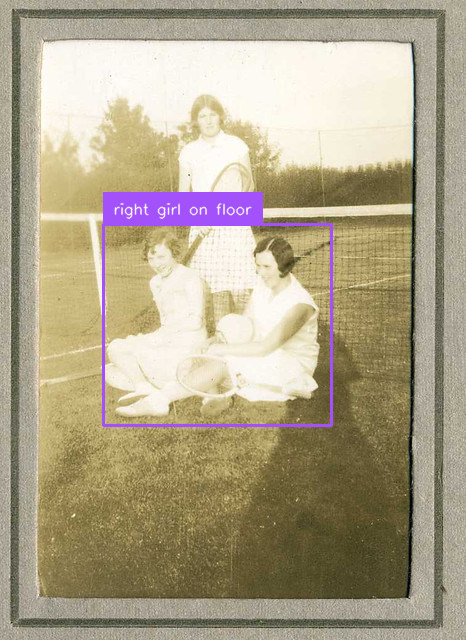

In [46]:
annotated_image

Nice! The model is now able to correctly recognize the **"right girl on floor"**.

### 5.3 Test Against a Validation Sample

Finally, let's evaluate the model's capabilities on a validation sample to properly assess whether it has learned both grounding and object detection.

In [180]:
image = val_dataset[13]['image']
caption = val_dataset[13]['caption']
caption

'darker bear'

In [183]:
prompt = f"<image>detect {caption}"
model_inputs = trained_processor(text=prompt, images=image, return_tensors="pt").to(torch.bfloat16).to(trained_model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = trained_model.generate(**model_inputs, max_new_tokens=100, do_sample=True)
    generation = generation[0][input_len:]
    output = trained_processor.decode(generation, skip_special_tokens=True)
    print(output)

<loc0016><loc0006><loc1022><loc0722> darker bear


In [184]:
width, height = image.size
parsed_labels = parse_paligemma_labels(output, width, height)
parsed_labels

[('darker bear', [3.75, 6.671875, 451.25, 426.166015625])]

In [185]:
annotated_image = get_annotated_image(image, parsed_labels)

Let's check... 🥁

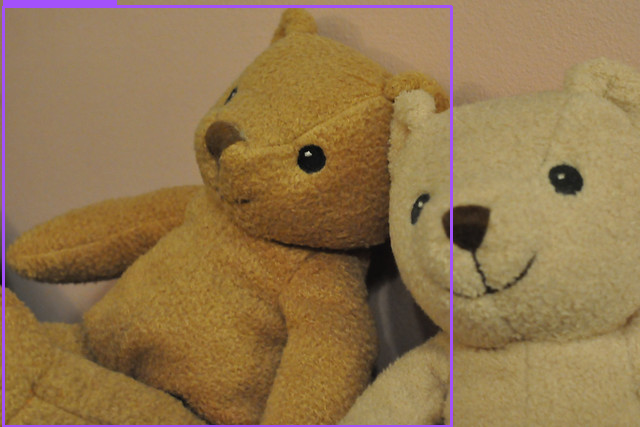

In [186]:
annotated_image

It works! Our model is able to correctly identify the **"darker bear"** in the image and avoids generating multiple detections for each bear.

Keep in mind that our training was light—using only a subset of the dataset—and the training configuration can be further optimized. We leave those improvements for you to explore!


## 6. Continuing the Learning Journey 🧑‍🎓️

To further enhance your understanding and skills, check out these valuable resources:

- [Fine-tuning Grounding DINO — LearnOpenCV](https://learnopencv.com/fine-tuning-grounding-dino/)
- [RefCOCO Dataset — Papers with Code](https://paperswithcode.com/dataset/refcoco)
- [Fine-tune PaliGemma — GitHub](https://github.com/ariG23498/fine-tune-paligemma)
- [Gemma3 Object Detection — GitHub](https://github.com/ariG23498/gemma3-object-detection)
- [VLM Object Understanding — Hugging Face Space](https://huggingface.co/spaces/sergiopaniego/vlm_object_understanding)
- [How Well Does GPT-4o Understand Vision? Evaluating Multimodal Foundation Models on Standard Computer Vision Tasks paper](https://fm-vision-evals.epfl.ch/)

Feel free to explore these to deepen your knowledge and keep pushing the boundaries!
